In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
device = torch.device("cpu")

### Defining netwroks with two linear layers. The network reads 3 parameters D_in, H, D_out, where H is the hidden dimension. The linear network works as two matrix multiplication. The first linear layer clamps output at 0 as RELU. The second linear layer output logits.

In [3]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, D_in, H, D_out):    
        super(TwoLayerNet, self).__init__()
        
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [4]:
# N=number of sample, D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
N, D_in, H, D_out = 50, 200, 100, 10
train_mus = range(D_out) # means centered each classification
train_sigma = 0.4 # standard deviation

# test mus step by 0.01 and start 0.5 below the lowest train_mu and end 0.5 above the
# largest train_mu
test_mus = np.arange(min(train_mus)-0.5,max(train_mus)+0.5,0.01)
test_sigma = train_sigma

# this s_factor will be used to scale all values down in the testing and training
# data so that calculations in the model are cleaner. This has shown to improve output
s_factor = 2*max(train_mus)
scale = lambda x: x/s_factor

scaled_train_mus = list(map(scale, train_mus)) 
scaled_train_sigma = scale(train_sigma)
scaled_test_sigma = scale(test_sigma)
scaled_test_mus = list(map(scale,test_mus))

# Learning rate
lr=5e-3
# Number of optimization
num_ops=100000 # try 10000!

## Predefined data
Each sample is a collection of points centered around a Gaussian distribution. Each sample's points are sorted. The training of the model is performed on scaled down versions of the input for better accuracy in calculations. 

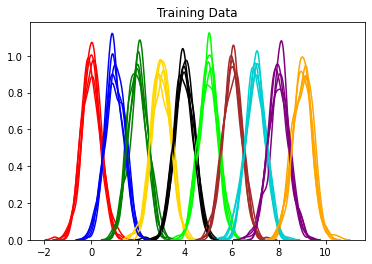

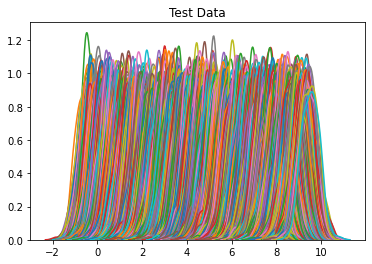

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9])


In [5]:
# Input data

X_train = torch.tensor(np.array([np.sort(np.random.normal(train_mus[i%D_out], train_sigma, D_in)) for i in range(N)]), dtype=torch.float32)
    
X_test = torch.tensor(np.array([np.sort(np.random.normal(test_mus[i], \
                                            test_sigma, D_in)) for i in range(len(test_mus))]), dtype=torch.float32)

scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)

y = torch.zeros(N, dtype=torch.long)
for i,x in enumerate(X_train):
    y[i] = round(float(torch.mean(x)))

colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
          7:'darkturquoise',8:'purple',9:'orange'}

for i, data in enumerate(X_train):
    sns.distplot(data, hist = False, color= colors[i%10])
plt.title('Training Data')
plt.show()
    
for x in X_test:
    sns.distplot(x, hist = False)
# plt.boxplot(X.tolist())
plt.title('Test Data')
plt.show()

print(y)

#### Classification Visualization

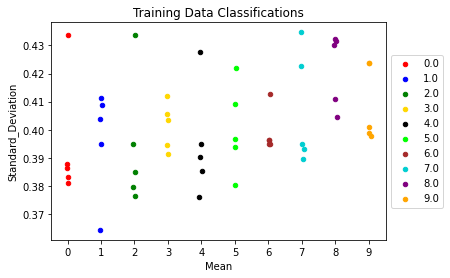

In [6]:
x_samples = []
for i,x in enumerate(X_train):
    x_i = [float(torch.mean(x)),float(torch.std(x)),y[i]]
    x_samples.append(x_i)

x_samples = np.array(x_samples)


df = pd.DataFrame(dict(Mean=x_samples[:,0], Standard_Deviation=x_samples[:,1], label=x_samples[:,2]))

colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
          7:'darkturquoise',8:'purple',9:'orange'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
plt.xticks(np.arange(min(train_mus),max(train_mus)+1,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Training Data Classifications')
plt.show()

In [7]:
print(X_train.shape)
print(y.shape)
print(X_test.shape)

torch.Size([50, 200])
torch.Size([50])
torch.Size([1000, 200])


### Predefined functions

In [8]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [9]:
model = TwoLayerNet(D_in, H, D_out)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Training

In [10]:
index = []
losses = []

for i in range(num_ops):
    Y=model(scaled_X_train)
    loss = loss_fn(Y,y)
    
    index.append(i)
    losses.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

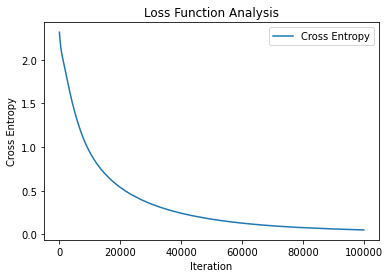

learning rate= 0.005
number of iterations= 100000


In [11]:
plt.plot(index,losses, label = 'Cross Entropy')
plt.title('Loss Function Analysis')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()
print('learning rate =',lr)
print('number of iterations =',num_ops)

# Output

### Checking performance of model
The first plot shows the distribution of test data classifications where each test sample is mapped to a particular classification and each classification has a violinplot of which sample means mapped to it.

Text(0.5, 1.0, 'Distributions of Test Data Classifications')

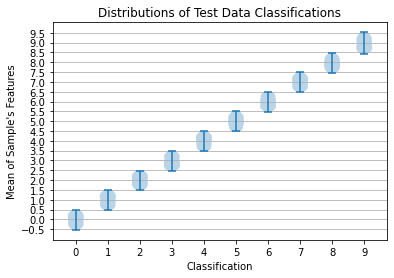

In [12]:
Y_test = list(map(lambda x: np.argmax(x), softmax(model(scaled_X_test)).detach().numpy()))

data = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
for i, x in enumerate(X_test):
    data[Y_test[i]].append(float(torch.mean(x)))
    
plt.violinplot(data.values(), positions = range(len(data.keys())))
plt.yticks(np.arange(min(test_mus),max(test_mus)+0.5,0.5))
plt.xticks(range(len(data.keys())))
plt.grid(axis='y')
plt.ylabel('Mean of Sample\'s Features')
plt.xlabel('Classification')
plt.title('Distributions of Test Data Classifications')

#### Classification plot
This plot shows each sample's standard deviation and mean and shows which classification it maps to based on its color.

In [13]:
samples = []
for i,x in enumerate(X_test):
    x_i = [float(torch.mean(x)),float(torch.std(x)),Y_test[i]]
    samples.append(x_i)

samples = np.array(samples)

df = pd.DataFrame(dict(Mean=samples[:,0], Standard_Deviation=samples[:,1], label=samples[:,2]))

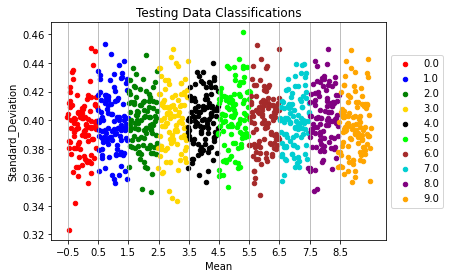

In [14]:
# colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
#          7:'darkturquoise',8:'purple',9:'orange'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
plt.xticks(np.arange(min(test_mus),max(test_mus),1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Testing Data Classifications')
plt.grid(axis='x')
plt.show()